# Twitter

Related Analysis Projects

- [Twitter's Own Interactive Data](https://interactive.twitter.com/)
- [UN Project on Twitter Analysis](http://post2015.unglobalpulse.net/)

Related Twitter Processing Frameworks

- [Datasift](http://datasift.com/products/open-data-processing-for-twitter/)


### Twitter Query
- Twitter has already been queried using the [Search Tweets API](https://dev.twitter.com/rest/reference/get/search/tweets). 
- returned JSON was written to `[query_term]_twitter_search_raw.json` file where each row in file is a tweet json object
- below is a query example

```python
import requests
from requests_oauthlib import OAuth1
import json

#define API url
url = 'https://api.twitter.com/1.1/search/tweets.json'

#define credentials
auth = OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)

query_term = input('Enter Twitter Search Term: ')

#define file for writing
json_f = open('[%s]_twitter_search_raw.json % query_term, 'a')

#writing decorator function    
def append_record(record):
    json_f.write(json.dumps(record, sort_keys=True))
    json_f.write('\n')
    json_f.flush()

#loop start here

#query parameters
payload = {'lang' : 'en', 'count' : 100, 'q' : query_term}

#make request
r = requests.get(url, params = payload, auth = auth)

#check status
#backoff when required

rj = r.json()

for result in rj['statuses']:
    append_record(result)

#loop

json_f.close()
```

* to automate for historical searching, simply loop the call [(note limits and good practices)](https://dev.twitter.com/rest/public)
* and recursively update payload max_id with latest tweet id
* alternatively for online data, use streaming api [(documentation)](https://dev.twitter.com/streaming/overview)

### Twitter Processing
* the below scripts transform JSON to clean database for later analysis
#### import tools

In [103]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
from pandas.tseries.offsets import *
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

#### define output database
- tweet raw JSON object looks like (flattened): ([documentation](https://dev.twitter.com/overview/api/tweets))

```
['contributors',
 'coordinates',
 'created_at',
 'entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'metadata',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'source',
 'text',
 'truncated',
 'user']
```

- list below is final columns we want
- added our own extracted columns
- dropped large dictionaries (entities, user)
- dropped others we don't want like deprecated geo, others like metadata, reply/quoted_status etc.

In [104]:
cols = [
    'id_str',
    'created_at',
    'source',
    'longitude',
    'latitude',
    'place_country',
    'place_name',
    'text',
    'lang',
    'tweet_type',
    'possibly_sensitive',
    'is_retweet',
    'is_reply',
    'is_quoted_tweet',
    'entities_media',
    'entities_urls',
    'entities_mentions',
    'entities_hashtags',
    'favorite_count',
    'retweet_count',
    'user_id_str',
    'user_screen_name',
    'user_created_at',
    'user_description',
    'user_location',
    'user_default_profile',
    'user_default_profile_image',
    'user_verified',
    'user_statuses',
    'user_favourites',
    'user_followers',
    'user_friends',
    'user_listed']

#### convert query term to file name keyword

In [105]:
keyword = input('Enter Twitter Query Term (event hashtag?): ')

Enter Twitter Query Term (event hashtag?): #rg16


In [106]:
keyword = keyword.replace(' ', '_').lower()
print(keyword)

#rg16


#### import data
- read json line by line
- convert list to pandas dataframe
    - flat json tree results in some columns still nested dicts

In [107]:
%%time
raw_data = []
with open('data/[%s]_twitter_search_raw.json' % keyword) as f:
    for line in f:
        raw_data.append(json.loads(line))
        
df = pd.DataFrame(raw_data)

Wall time: 14 s


#### dedupe
- on twitter id, in case of searching errors

In [108]:
df.drop_duplicates('id_str', inplace=True)
df.shape

(102335, 29)

#### clean text field
- remove new lines, carriage returns

In [109]:
df['text'] = df['text'].apply(lambda s: s.replace('\n', ' ').replace('\r', ' '))

#### source
- extract source text from html source object

In [110]:
df['source'] = df['source'].apply(lambda s: BeautifulSoup(s, 'html.parser').text)

#### coordinates
- extract lat, lon from tweet if known, else NaN

In [111]:
df['longitude'] = df['coordinates'].apply(lambda c: (c['coordinates'][0] if c != None else np.nan))
df['latitude'] = df['coordinates'].apply(lambda c: (c['coordinates'][1] if c != None else np.nan))

#### place
- extract place name, country if known else NaN
- place also contains geojson object, place type etc. ([documentation](https://dev.twitter.com/overview/api/places))

In [112]:
df['place_country'] = df['place'].apply(lambda p: (p['country'] if p != None else np.nan))
df['place_name'] = df['place'].apply(lambda p: (p['full_name'] if p != None else np.nan))

#### classify tweet type
- check for 'media' key in entities dictionary, else 'text'

In [113]:
df['tweet_type'] = df['entities'].apply(lambda e: ['text','media']['media' in e])

#### mark retweets
- using character matching to 'RT @' or 'RT :'

In [114]:
df['is_retweet'] = df['text'].apply(lambda t: [0,1][t.startswith(('RT @', 'RT :'))])

#### mark replies
- using twitter's 'in_reply_to_status_id' field, where not null is encoded 1 as reply

In [115]:
df['is_reply'] = df['in_reply_to_status_id'].apply(lambda r: [1,0][np.isnan(r)])

#### mark quoted tweets
- using twitter's 'quoted_status_id' field, where not null is encoded 1 as quoted tweet

In [116]:
df['is_quoted_tweet'] = df['quoted_status_id'].apply(lambda r: [1,0][np.isnan(r)])

#### transform useful data
- using twitter's nicely organized entities, user objects
- extract entities ([documentation](https://dev.twitter.com/overview/api/entities-in-twitter-objects#tweets))
- extract user info ([documentation](https://dev.twitter.com/overview/api/entities-in-twitter-objects#users))
- some info was ignored for the purpose of this project

In [1]:
#entities
df['entities_media'] = df['entities'].apply(lambda e: [media['media_url_https'] for media in (e['media'] if 'media' in e else {})])
df['entities_urls'] = df['entities'].apply(lambda e: [url for url in [urlobject['expanded_url'] for urlobject in e['urls']]])
df['entities_mentions'] = df['entities'].apply(lambda e: [mention for mention in [mentionobject['screen_name'] for mentionobject in e['user_mentions']]])
df['entities_hashtags'] = df['entities'].apply(lambda e: [tag for tag in [tagobject['text'] for tagobject in e['hashtags']]])

NameError: name 'df' is not defined

In [118]:
#user
df['user_id_str'] = df['user'].apply(lambda u: u['id_str'])
df['user_screen_name'] = df['user'].apply(lambda u: u['screen_name'].replace('\n', '').replace('\r', ''))
df['user_created_at'] = df['user'].apply(lambda u: pd.to_datetime(u['created_at'], format='%a %b %d %H:%M:%S +0000 %Y'))
df['user_description'] = df['user'].apply(lambda u: u['description'].replace('\n', ' ').replace('\r', ' '))
df['user_location'] = df['user'].apply(lambda u: u['location'].replace('\n', ' ').replace('\r', ' '))
df['user_default_profile'] = df['user'].apply(lambda u: u['default_profile'])
df['user_default_profile_image'] = df['user'].apply(lambda u: u['default_profile_image'])
df['user_verified'] = df['user'].apply(lambda u: u['verified'])
df['user_statuses'] = df['user'].apply(lambda u: u['statuses_count'])
df['user_favourites'] = df['user'].apply(lambda u: u['favourites_count'])
df['user_followers'] = df['user'].apply(lambda u: u['followers_count'])
df['user_friends'] = df['user'].apply(lambda u: u['friends_count'])
df['user_listed'] = df['user'].apply(lambda u: u['listed_count'])

#### apply output columns filter

In [119]:
df = df[cols]
df.shape

(102335, 33)

#### datetime
- convert string to pandas datetime
- used for plotting, and datetime accessors
- twitter datetime was already converted to 'YYYY-MM-DD' in searching script
- alternatively if not, use the below twitter datetime conversion

```
pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S +0000 %Y')
```

In [120]:
df.loc[:,('created_at')] = pd.to_datetime(df['created_at'])
df = df.sort_values(by='created_at', ascending=True)

#### plot timeseries of search
- get tweet volume counts on frequency level hour
- useful time groupers offset aliases: 'D'=day H'=hour 'T'=minute [documentation](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases)
- note twitter times are UTC

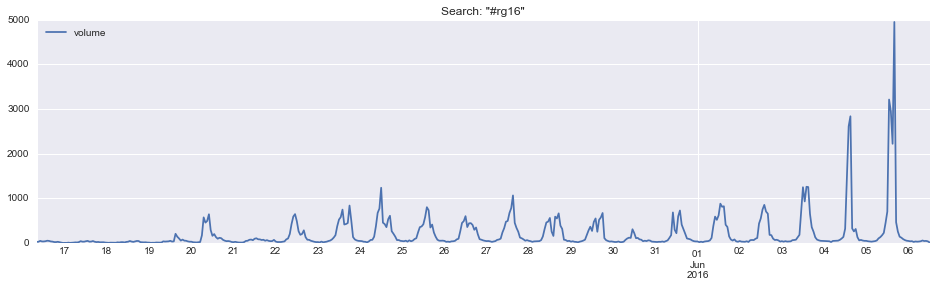

In [121]:
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['id_str'].agg(['count'])
timeframe = pd.date_range(d.index.min(), d.index.max(), freq='H')
d = d.reindex(timeframe, fill_value=0)

plt.title('Search: "%s"' % keyword)
ax = d['count'].plot(figsize=(16,4), label='volume')
plt.legend(loc='best')
plt.show()

## Define Event
#### date range
- we define the data range as -1 day to +1 day from the event dates in UTC time
- this way we can comfortably handle global events, and store events equally
- replot tweet volume over time, using new event timeframe

In [122]:
startdate = pd.to_datetime(input('Enter Event Start Date (YYYY-MM-DD): '))
enddate = pd.to_datetime(input('Enter Event End Date (YYYY-MM-DD): '))

start = startdate - DateOffset(days=1)
finish = enddate + DateOffset(days=2)

timeframe = pd.date_range(start, finish, freq='H')

Enter Event Start Date (YYYY-MM-DD): 2016-05-22
Enter Event End Date (YYYY-MM-DD): 2016-06-05


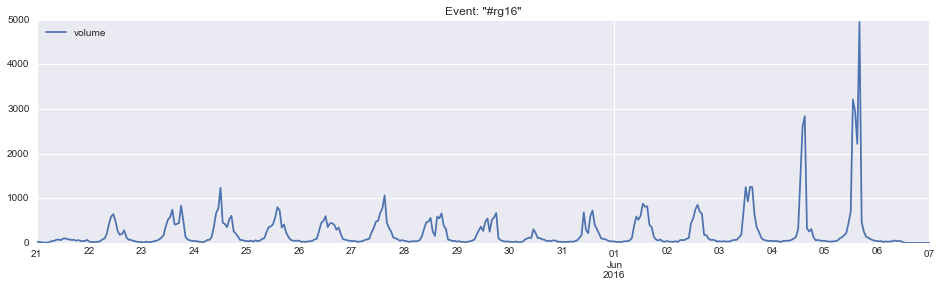

In [123]:
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['id_str'].agg(['count'])
d = d.reindex(timeframe, fill_value=0)

plt.title('Event: "%s"' % keyword)
ax = d['count'].plot(figsize=(16,4), label='volume')
plt.legend(loc='best')
plt.show()

#### trim excess tweets

In [124]:
df = df[(df['created_at'] >= start) & (df['created_at'] < finish)]
df.shape

(96008, 33)

#### remove retweets, replies, quoted tweets

In [125]:
df = df[(df['is_retweet'] == 0) & (df['is_reply'] == 0) & (df['is_quoted_tweet'] == 0)]
df.shape

(86791, 33)

#### add index as master id, rename twitter id

In [126]:
df.reset_index(drop=True, inplace=True)
df = df.reset_index().rename(columns={'index' : 'event_id', 'id_str' : 'twitter_id'})

#### add event name

In [127]:
event_name = input('Enter Event Name: ')
event_filename = re.sub("\W+", "", event_name.strip())
df.loc[:,'event'] = event_name

Enter Event Name: The French Open


#### export event master datafile

In [128]:
df.to_csv('data/final/event_%s_data.txt' % event_filename, sep='\t', encoding='utf-8', header=True, index=False)

## Annotation

#### get annotation data
- define data that will go to crowdflower for annotation
- sample 1k
- add event title, description

In [129]:
#df_smpl = df.sample(100, random_state=2016)[['event', 'event_id', 'twitter_id', 'created_at', 'text']]

In [130]:
#df_smpl.loc[:,'event_description'] = input('Enter Event Description: ')

In [131]:
#reindex to datetime, groupby hour, count id's
#d = df_smpl.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
#d = d.reindex(timeframe, fill_value=0)

#plt.title('Event Sample: "%s"' % keyword)
#ax = d['count'].plot(figsize=(16,4), label='volume')
#plt.legend(loc='best')
#plt.show()

#### export sample

In [132]:
#format for crowdflower import
#delimited by ','
#double quote strings
#xy.to_csv('data/final/events_annsample_forcrowdflower_manual.csv', sep=',', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8', header=True, index=False)

### Explore Data (Simple)
#### tweet type
* plot tweet counts by type

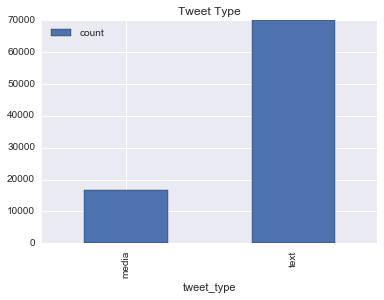

In [133]:
df.groupby('tweet_type')['twitter_id'].agg(['count']).plot(kind='bar', title='Tweet Type')
plt.show()

#### tweet type over time

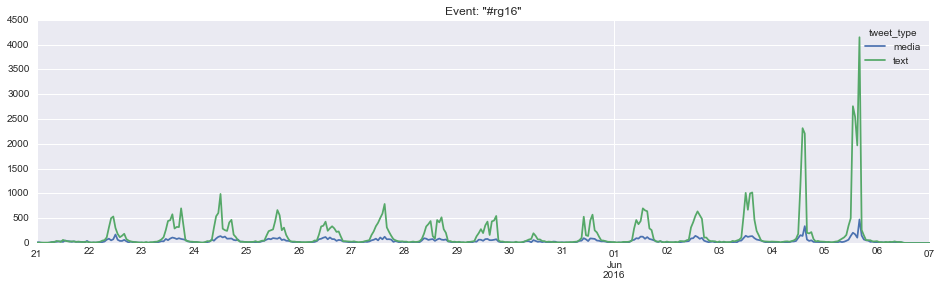

In [134]:
d = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H'), 'tweet_type'])['twitter_id'].agg(['count']).unstack(level='tweet_type', fill_value=0)
d = d.reindex(timeframe, fill_value=0)
d.columns = d.columns.droplevel(0)

d.plot(figsize=(16,4), title='Event: "%s"' % keyword)
plt.show()

#### source utility
* plot tweet counts by top 10 source utility

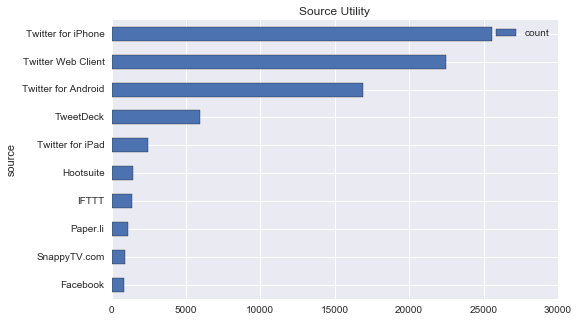

In [135]:
df.groupby('source')['twitter_id'].agg(['count']).sort_values(by='count', ascending=True)[-10:].plot(kind='barh', figsize=(8,5), title='Source Utility')
plt.show()

#### source place
* plot tweet counts by top 10 place names
* this data is user specificed, and not consistent/clean

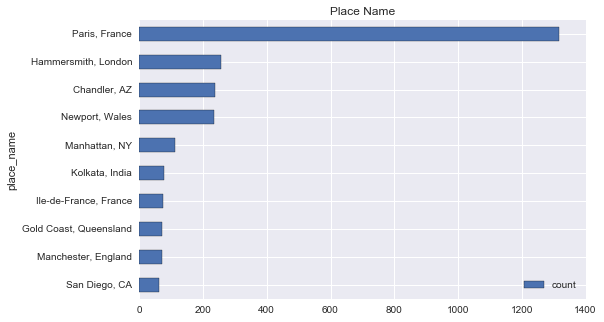

In [136]:
df.groupby('place_name')['twitter_id'].agg(['count']).sort_values(by='count', ascending=True)[-10:].plot(kind='barh', figsize=(8,5), title='Place Name')
plt.show()